In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import shutil
from ipywidgets import FloatProgress
from IPython.display import display
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# open ship segmentations and save only those with 1 ship in it
data_dir = '../../data/airbus/'
df = pd.read_csv(data_dir + 'train_ship_segmentations.csv')
filtered_df = df[df.groupby("ImageId")["ImageId"].transform('size') == 1]
filtered_df = filtered_df.dropna()
filtered_df.to_csv(data_dir + 'train_ship_segmentations_1_ship.csv', index=False)

In [24]:
# create csv including ImageId and bboxes

from ipywidgets import FloatProgress
from IPython.display import display
import time

# open mask package for decoding mask_rle to rotated bboxes
from masks.bbox import *

def decode_pixels(encoded_pixels):
    img_masks = encoded_pixels.tolist()
    bboxs = []
    for mask in img_masks:
         bb = bbox()
         bb_str = bb.from_mask(mask).get_as_str()
         bboxs.append( bb_str )
            
    return bboxs

def rle_to_bbs(row, masks):
    
    encoded_pixels = masks.loc[masks['ImageId'] == row['ImageId'], 'EncodedPixels']
    
    if( not pd.isna(row['EncodedPixels'])):
        return decode_pixels(encoded_pixels)[0]
    else:
        return row['EncodedPixels']

data_dir = '../../data/airbus/'
df = pd.read_csv(data_dir + 'train_ship_segmentations_1_ship.csv')

(rows, columns) = df.shape
f = FloatProgress(min=0, max=rows) # instantiate the bar
display(f) # display the bar

bboxes = []
for index,row in df.iterrows():
    bboxes.append(rle_to_bbs(row, df))
    f.value += 1 # signal to increment the progress bar
    
df = df.assign(BBoxes = bboxes)
df = df[['ImageId', 'BBoxes']]
df.to_csv(data_dir + 'train_ship_bbox_1_ship.csv')

FloatProgress(value=0.0, max=18525.0)

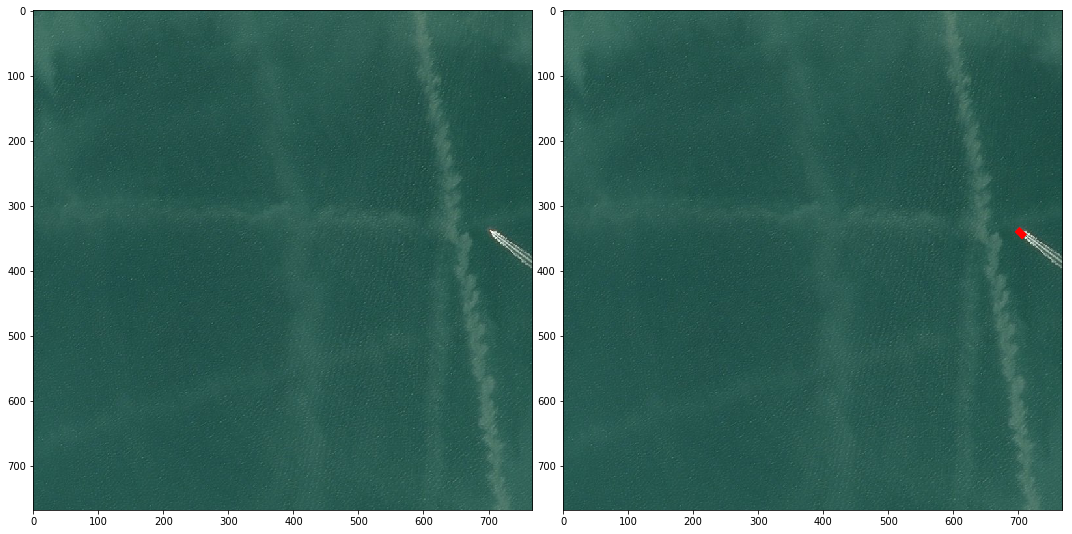

In [33]:
# 3. testing - open and display images
from skimage.data import imread
from masks.bbox import *

bbox = bbox()

data_dir = '../../data/airbus/'
df = pd.read_csv(data_dir + 'train_ship_bbox_1_ship.csv')
    
def plot_img_with_boxes(train_dir, image_id, bboxes):
    img_path = train_dir + image_id
    img = imread(img_path)
    fig, axarr = plt.subplots(1, 2, figsize=(15, 40))
    axarr[0].imshow(img)
    axarr[1].imshow(img)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    bbox.from_string(bboxes).plot_bbox(plt)
    plt.show()
    
index = 41
ImageId = df.iloc[index].ImageId
BBoxes = df.iloc[index].BBoxes

plot_img_with_boxes(data_dir + 'train/', ImageId, BBoxes)